In [1]:
import os
import sys

PROJECT_MARKERS = ("src", "data", "prompts", "results")

def find_project_root(start_path):
    current = os.path.abspath(start_path)

    while True:
        if all(os.path.isdir(os.path.join(current, m)) for m in PROJECT_MARKERS):
            return current

        parent = os.path.dirname(current)
        if parent == current:
            raise RuntimeError("Project root not found")

        current = parent


# ---- execution directory (cwd) ----
cwd = os.getcwd()

# ---- safe starting point ----
try:
    start_path = os.path.dirname(os.path.abspath(__file__))
except NameError:
    start_path = cwd


# ---- resolve canonical paths ----
project_root = find_project_root(start_path)

# ✅ THIS IS THE IMPORTANT PART
if project_root not in sys.path:
    sys.path.insert(0, project_root)

src_root     = os.path.join(project_root, "src", "daniel", "gemini")
data_root    = os.path.join(project_root, "data", "MAMS-ACSA", "raw", "data_jsonl", "annotated")
schemas_root = os.path.join(project_root, "data", "MAMS-ACSA", "raw", "data_jsonl", "schema")
prompts_root = os.path.join(project_root, "prompts", "daniel", "llama")
utils_root   = os.path.join(project_root, "utils")
results_root = os.path.join(project_root, "results", "daniel")

print(
    f"📂 cwd          : {cwd}\n"
    f"📂 Project root : {project_root}\n"
    f"📂 Source root  : {src_root}\n"
    f"📂 Data root    : {data_root}\n"
    f"📂 Prompts root : {prompts_root}\n"
    f"📂 Utils root   : {utils_root}\n"
    f"📂 Results root : {results_root}"
)

📂 cwd          : /Users/hd/Desktop/RCS-Emotion-Prediction-2025/src/daniel/metrics
📂 Project root : /Users/hd/Desktop/RCS-Emotion-Prediction-2025
📂 Source root  : /Users/hd/Desktop/RCS-Emotion-Prediction-2025/src/daniel/gemini
📂 Data root    : /Users/hd/Desktop/RCS-Emotion-Prediction-2025/data/MAMS-ACSA/raw/data_jsonl/annotated
📂 Prompts root : /Users/hd/Desktop/RCS-Emotion-Prediction-2025/prompts/daniel/llama
📂 Utils root   : /Users/hd/Desktop/RCS-Emotion-Prediction-2025/utils
📂 Results root : /Users/hd/Desktop/RCS-Emotion-Prediction-2025/results/daniel


In [2]:
# VALIDATION BLOCK

import json
import os
from collections import Counter

# -----------------------------
# Paths
# -----------------------------
GOLD_PATH = os.path.join(data_root, "edited_300_sample_cleaned_14jan.jsonl")
#PRED_PATH = os.path.join(results_root, "gpt", "gpt_output_v3.jsonl")
#PRED_PATH = os.path.join(results_root, "gpt", "gpt_output _with_polarity_v3.jsonl")
#PRED_PATH = os.path.join(results_root, "gpt", "gpt_output_new_prompt_v1.jsonl")
PRED_PATH = os.path.join(results_root, "gpt", "gpt_output_new_prompt_no_polarity_v1.jsonl")
#PRED_PATH = os.path.join(results_root, "gpt", "gpt_output_new_prompt_v1.jsonl")

# Print the files in use are 

print(f"Using GOLD file: {GOLD_PATH}")
print(f"Using PRED file: {PRED_PATH}")

input_name = os.path.splitext(os.path.basename(PRED_PATH))[0]
AUDIT_PATH = os.path.join(
    results_root, f"audit_invalid_rows_{input_name}.jsonl"
)

# -----------------------------
# Load JSONL
# -----------------------------
def load_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]

gold = load_jsonl(GOLD_PATH)
pred = load_jsonl(PRED_PATH)

assert len(gold) == len(pred), "Row count mismatch!"

# -----------------------------
# Validation
# -----------------------------
invalid_rows = []
valid_indices = []

for idx, (g, p) in enumerate(zip(gold, pred)):

    # Rule 1: input must match
    if g["input"] != p["input"]:
        invalid_rows.append({
            "index": idx,
            "reason": "input_mismatch",
            "gold_input": g["input"],
            "pred_input": p["input"]
        })
        continue

    g_out = g["output"]
    p_out = p["output"]

    # Rule 2: same number of triples
    if len(g_out) != len(p_out):
        invalid_rows.append({
            "index": idx,
            "reason": "output_count_mismatch",
            "input": g["input"],
            "gold_count": len(g_out),
            "pred_count": len(p_out),
            "gold_output": g_out,
            "pred_output": p_out
        })
        continue

    # Rule 3: same (aspect, polarity)
    g_pairs = Counter((o["aspect"], o["polarity"]) for o in g_out)
    p_pairs = Counter((o["aspect"], o["polarity"]) for o in p_out)

    if g_pairs != p_pairs:
        invalid_rows.append({
            "index": idx,
            "reason": "aspect_polarity_mismatch",
            "input": g["input"],
            "gold_aspect_polarity": [
                {"aspect": a, "polarity": p, "count": c}
                for (a, p), c in g_pairs.items()
            ],
            "pred_aspect_polarity": [
                {"aspect": a, "polarity": p, "count": c}
                for (a, p), c in p_pairs.items()
            ],
        })
        continue

    # Row is valid
    valid_indices.append(idx)

# -----------------------------
# Report + save
# -----------------------------
print("VALIDATION SUMMARY")
print("------------------")
print(f"Total rows : {len(gold)}")
print(f"Valid rows : {len(valid_indices)}")
print(f"Invalid    : {len(invalid_rows)}")

if invalid_rows:
    with open(AUDIT_PATH, "w", encoding="utf-8") as f:
        for r in invalid_rows:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")

    print(f"\nInvalid rows written to:")
    print(AUDIT_PATH)

Using GOLD file: /Users/hd/Desktop/RCS-Emotion-Prediction-2025/data/MAMS-ACSA/raw/data_jsonl/annotated/edited_300_sample_cleaned_14jan.jsonl
Using PRED file: /Users/hd/Desktop/RCS-Emotion-Prediction-2025/results/daniel/gpt/gpt_output_new_prompt_no_polarity_v1.jsonl
VALIDATION SUMMARY
------------------
Total rows : 299
Valid rows : 282
Invalid    : 17

Invalid rows written to:
/Users/hd/Desktop/RCS-Emotion-Prediction-2025/results/daniel/audit_invalid_rows_gpt_output_new_prompt_no_polarity_v1.jsonl


Used 537 emotion labels for evaluation

EMOTION-ONLY EVALUATION REPORT
--------------------------------
Emotion Macro-F1      : 0.9031
Emotion Micro-F1      : 0.9609
Exact Emotion Accuracy: 0.9609

DETAILED EMOTION REPORT

                precision    recall  f1-score   support

    admiration       0.94      0.95      0.95       108
     annoyance       0.98      1.00      0.99        86
disappointment       1.00      0.97      0.99       117
       disgust       0.80      1.00      0.89         4
     gratitude       1.00      0.33      0.50         6
mentioned_only       0.93      1.00      0.97        97
mixed_emotions       1.00      1.00      1.00        10
       neutral       0.97      0.81      0.89        43
  satisfaction       0.94      0.98      0.96        66

      accuracy                           0.96       537
     macro avg       0.95      0.90      0.90       537
  weighted avg       0.96      0.96      0.96       537


CONFUSION MATRIX (COUNTS — COMPACT)

       P

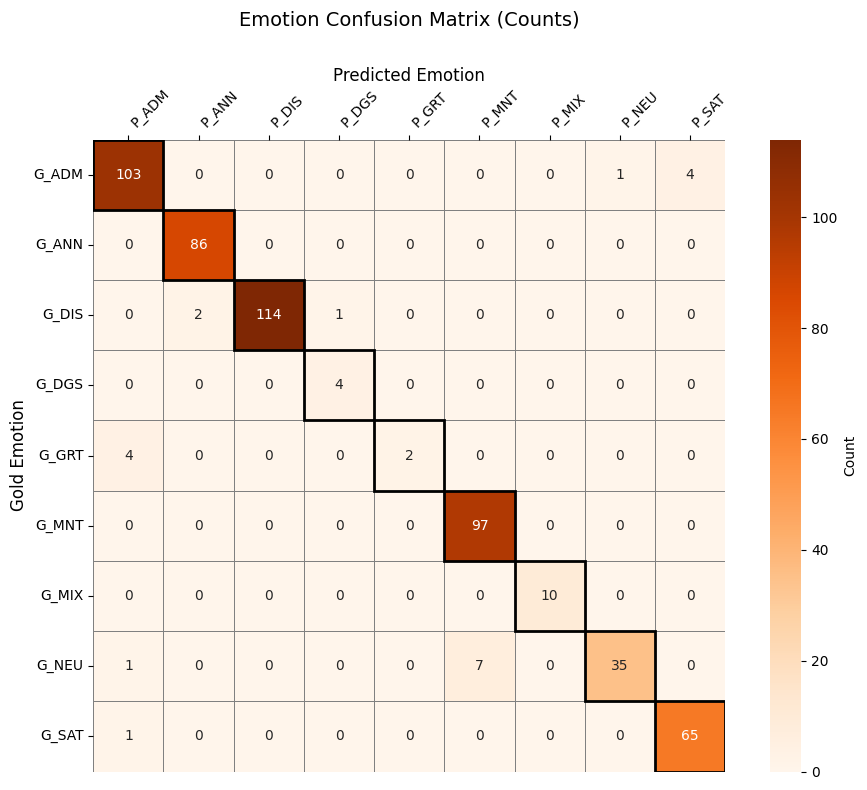

Saved PNG → confusion_matrix_emotion_counts_gpt_output_new_prompt_no_polarity_v1.png


In [3]:
import pandas as pd
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


gold_emotions = []
pred_emotions = []

for idx in valid_indices:
    g_out = gold[idx]["output"]
    p_out = pred[idx]["output"]

    # Safe: structure already validated
    for g, p in zip(g_out, p_out):
        gold_emotions.append(g["emotion"])
        pred_emotions.append(p["emotion"])

print(f"Used {len(gold_emotions)} emotion labels for evaluation")

emotion_macro = f1_score(
    gold_emotions, pred_emotions,
    average="macro", zero_division=0
)

emotion_micro = f1_score(
    gold_emotions, pred_emotions,
    average="micro", zero_division=0
)

emotion_accuracy = sum(
    g == p for g, p in zip(gold_emotions, pred_emotions)
) / len(gold_emotions)

print("\nEMOTION-ONLY EVALUATION REPORT")
print("--------------------------------")
print("Emotion Macro-F1      :", round(emotion_macro, 4))
print("Emotion Micro-F1      :", round(emotion_micro, 4))
print("Exact Emotion Accuracy:", round(emotion_accuracy, 4))

print("\nDETAILED EMOTION REPORT\n")

detailed_report = classification_report(
    gold_emotions,
    pred_emotions,
    zero_division=0
)

print(detailed_report)
EMOTION_ABBR = {
    "admiration":       "ADM",
    "annoyance":        "ANN",
    "disappointment":  "DIS",
    "disgust":          "DGS",
    "gratitude":        "GRT",
    "mentioned_only":   "MNT",
    "mixed_emotions":   "MIX",
    "no_emotion":       "NON",
    "satisfaction":    "SAT",
    "neutral":          "NEU"
}
# -----------------------------
# CONFUSION MATRIX (Emotion)
# -----------------------------

labels = sorted(set(gold_emotions))

cm = confusion_matrix(
    gold_emotions,
    pred_emotions,
    labels=labels
)

cm_df = pd.DataFrame(
    cm,
    index=[f"G_{EMOTION_ABBR[l]}" for l in labels],
    columns=[f"P_{EMOTION_ABBR[l]}" for l in labels]
)

print("\nCONFUSION MATRIX (COUNTS — COMPACT)\n")
print(cm_df)

print("\n==============================")

cm_norm = confusion_matrix(
    gold_emotions,
    pred_emotions,
    labels=labels,
    normalize="true"
)

cm_norm_df = pd.DataFrame(
    cm_norm,
    index=[f"G_{EMOTION_ABBR[l]}" for l in labels],
    columns=[f"P_{EMOTION_ABBR[l]}" for l in labels]
)

print("\nCONFUSION MATRIX (NORMALIZED — COMPACT)\n")
print(cm_norm_df.round(2))


cm_out = f"confusion_matrix_emotion_compact_{input_name}.csv"
cm_norm_out = f"confusion_matrix_emotion_compact_norm_{input_name}.csv"

cm_df.to_csv(cm_out)
cm_norm_df.to_csv(cm_norm_out)

print("\nSaved confusion matrices:")
print(cm_out)
print(cm_norm_out)



plt.figure(figsize=(10, 8))

ax = sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Oranges",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Count"},
    square=True
)

# --- move column labels to TOP ---
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

# rotate for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="left")
plt.setp(ax.get_yticklabels(), rotation=0)

# emphasize diagonal
for i in range(len(cm_df)):
    ax.add_patch(
        plt.Rectangle(
            (i, i), 1, 1,
            fill=False,
            edgecolor="black",
            lw=2
        )
    )

plt.title("Emotion Confusion Matrix (Counts)", fontsize=14, pad=30)
plt.xlabel("Predicted Emotion", fontsize=12)
plt.ylabel("Gold Emotion", fontsize=12)

plt.tight_layout()

# save as PNG
png_path = f"confusion_matrix_emotion_counts_{input_name}.png"
plt.savefig(png_path, dpi=300)
plt.show()

print(f"Saved PNG → {png_path}")

In [4]:
# ============================================================
# ASPECT + POLARITY + EMOTION EVALUATION (STRICT ORDER MATCH)
# ============================================================
#
# What this script DOES:
# - Aligns gold/pred by exact "input" text (sentence-level alignment)
# - Enforces: same number of triplets per sentence (count match)
# - Enforces: same order by position (triplet i in gold compared to triplet i in pred)
# - Evaluates THREE label types separately:
#     1) aspect
#     2) polarity
#     3) emotion
#
# What this script DOES NOT do:
# - No re-ordering, no fuzzy matching, no deduplication
# - If the model changes triplet count for a sentence → that sentence is excluded & logged
#
# Why this is correct for your setup:
# - Your dataset defines the "structure" (triplets and their order).
# - Models are allowed to predict labels; we evaluate them only when structure is comparable.
# ============================================================

import json
import os
import pandas as pd
from sklearn.metrics import f1_score, classification_report

# -----------------------------
# Paths
# -----------------------------
GOLD_PATH = os.path.join(data_root, "edited_300_sample_cleaned_14jan.jsonl")
PRED_PATH = os.path.join(results_root, "gpt", "gpt_output_new_prompt_no_polarity_v1.jsonl")
#PRED_PATH = os.path.join(results_root, "gpt", "gpt_output_new_prompt_v1.jsonl")
#PRED_PATH = os.path.join(results_root, "gpt", "gpt_output _with_polarity_v3.jsonl")
#PRED_PATH = os.path.join(results_root, "gpt", "gpt_output_v3.jsonl")
#GOLD_PATH = os.path.join(data_root, "02_iteration_cleaned_300.jsonl")

# Choose exactly ONE prediction file
#PRED_PATH = os.path.join(results_root, "llama", "llama_output.jsonl")
#PRED_PATH = os.path.join(results_root, "claude", "claude_output.jsonl")
# PRED_PATH = os.path.join(results_root, "gpt", "gpt_output.jsonl")
#PRED_PATH = os.path.join(results_root, "deepseek", "deep_seek_output.jsonl")
#PRED_PATH = os.path.join(results_root, "llama", "llama_output_updated.jsonl")

# Tag outputs with model/file name
input_name = os.path.splitext(os.path.basename(PRED_PATH))[0]

# -----------------------------
# Load JSONL
# -----------------------------
def load_jsonl(path: str):
    """Load a JSONL file into a list of dicts (one JSON object per line)."""
    with open(path, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]

gold = load_jsonl(GOLD_PATH)
pred = load_jsonl(PRED_PATH)

# -----------------------------
# Align by input text
# -----------------------------
# NOTE: If duplicate "input" texts exist in a file, dict will keep only the LAST one.
gold_map = {row["input"]: row["output"] for row in gold}
pred_map = {row["input"]: row["output"] for row in pred}

print(f"Loaded gold rows: {len(gold_map)}")
print(f"Loaded pred rows: {len(pred_map)}")

# -----------------------------
# Collect aligned labels
# -----------------------------
gold_aspects, pred_aspects = [], []
gold_polarities, pred_polarities = [], []
gold_emotions, pred_emotions = [], []

mismatches = []

for text, gold_list in gold_map.items():
    pred_list = pred_map.get(text)

    # Case 1: sentence missing in prediction file
    if pred_list is None:
        mismatches.append({
            "input": text,
            "reason": "MISSING_PREDICTION",
            "gold_count": len(gold_list),
            "pred_count": 0,
            "gold_output": gold_list,
            "pred_output": []
        })
        continue

    # Case 2: triplet count mismatch (structure not comparable)
    if len(pred_list) != len(gold_list):
        mismatches.append({
            "input": text,
            "reason": "TRIPLE_COUNT_MISMATCH",
            "gold_count": len(gold_list),
            "pred_count": len(pred_list),
            "gold_output": gold_list,
            "pred_output": pred_list
        })
        continue

    # Case 3: strict order-by-position comparison
    # We compare triplet i with triplet i. No re-matching.
    for idx, (g, p) in enumerate(zip(gold_list, pred_list)):
        # Extract labels from gold (always present if gold is clean)
        g_aspect = g.get("aspect")
        g_polarity = g.get("polarity")
        g_emotion = g.get("emotion")

        # Extract labels from pred (use .get to avoid KeyError; missing becomes None)
        p_aspect = p.get("aspect")
        p_polarity = p.get("polarity")
        p_emotion = p.get("emotion")

        # If a model forgets a field entirely, log it as a structural issue
        # (because you cannot evaluate a missing label fairly).
        if p_aspect is None or p_polarity is None or p_emotion is None:
            mismatches.append({
                "input": text,
                "reason": "MISSING_FIELDS_IN_TRIPLE",
                "index": idx,
                "gold_triple": g,
                "pred_triple": p
            })
            # Discard the whole sentence to keep evaluation strict and comparable
            break

        # Append aligned labels
        gold_aspects.append(g_aspect);     pred_aspects.append(p_aspect)
        gold_polarities.append(g_polarity); pred_polarities.append(p_polarity)
        gold_emotions.append(g_emotion);   pred_emotions.append(p_emotion)
    else:
        # The for-loop didn't break -> sentence was fully processed
        continue

    # If we broke due to missing fields, we should remove any partially appended labels
    # for this sentence. Easiest strict approach: avoid partial contamination by rewinding.
    # We know exactly how many triplets were in the sentence: len(gold_list)
    # BUT we may have broken early at idx, so we must remove (idx already appended?) careful:
    # In this code, we append only AFTER missing-field check, so if we break, nothing for that idx
    # but earlier triplets of this sentence WERE appended. We must remove those.
    k = 0
    # Count how many from this sentence were appended before break:
    # that's exactly the number of iterations completed before break,
    # which equals the current idx value at break time.
    # However idx is out of scope here, so we recompute based on the mismatch record.
    # Minimal safe approach: remove len(gold_list) labels ONLY if we processed the full sentence.
    # Since we broke, we need to remove the already-added part:
    last = mismatches[-1]
    if last.get("reason") == "MISSING_FIELDS_IN_TRIPLE" and last.get("input") == text:
        k = last.get("index", 0)
        if k > 0:
            del gold_aspects[-k:]; del pred_aspects[-k:]
            del gold_polarities[-k:]; del pred_polarities[-k:]
            del gold_emotions[-k:]; del pred_emotions[-k:]

# -----------------------------
# Save mismatches
# -----------------------------
if mismatches:
    mismatch_path = f"full_task_mismatches_{input_name}.jsonl"
    with open(mismatch_path, "w", encoding="utf-8") as f:
        for row in mismatches:
            f.write(json.dumps(row, ensure_ascii=False) + "\n")

    print(f"\n⚠️  Found {len(mismatches)} invalid sentences")
    print(f"Saved mismatches → {mismatch_path}")
else:
    print("\n✅ No mismatches found")

print(f"Used {len(gold_emotions)} aligned triplets for evaluation (3 labels each)")

# -----------------------------
# Metric helper
# -----------------------------
def eval_labels(gold_labels, pred_labels, name: str):
    """Compute macro/micro F1 + accuracy and generate a detailed classification report."""
    macro = f1_score(gold_labels, pred_labels, average="macro", zero_division=0)
    micro = f1_score(gold_labels, pred_labels, average="micro", zero_division=0)
    acc = sum(g == p for g, p in zip(gold_labels, pred_labels)) / len(gold_labels) if gold_labels else 0.0

    report = classification_report(gold_labels, pred_labels, zero_division=0)
    # Add a readable header without duplicating sklearn's header:
    # We only prepend a label column name line; sklearn prints precision/recall/f1/support itself.
    header = f"{name:<16}precision    recall  f1-score   support"
    report = header + "\n" + report

    return macro, micro, acc, report

# -----------------------------
# Compute metrics for each label type
# -----------------------------
aspect_macro, aspect_micro, aspect_acc, aspect_report = eval_labels(gold_aspects, pred_aspects, "aspect")
pol_macro, pol_micro, pol_acc, pol_report = eval_labels(gold_polarities, pred_polarities, "polarity")
emo_macro, emo_micro, emo_acc, emo_report = eval_labels(gold_emotions, pred_emotions, "emotion")

# -----------------------------
# Print summary
# -----------------------------
print("\n==============================")
print("FULL TASK EVALUATION SUMMARY")
print("==============================\n")

print("ASPECT   - Macro-F1:", round(aspect_macro, 4), " Micro-F1:", round(aspect_micro, 4), " Acc:", round(aspect_acc, 4))
print("POLARITY - Macro-F1:", round(pol_macro, 4),    " Micro-F1:", round(pol_micro, 4),    " Acc:", round(pol_acc, 4))
print("EMOTION  - Macro-F1:", round(emo_macro, 4),    " Micro-F1:", round(emo_micro, 4),    " Acc:", round(emo_acc, 4))

print("\n==============================")
print("DETAILED REPORTS")
print("==============================\n")

print("\n--- ASPECT REPORT ---\n")
print(aspect_report)

print("\n--- POLARITY REPORT ---\n")
print(pol_report)

print("\n--- EMOTION REPORT ---\n")
print(emo_report)

# -----------------------------
# Save metrics in ONE CSV
# -----------------------------
df = pd.DataFrame({
    "Aspect Macro F1": [aspect_macro],
    "Aspect Micro F1": [aspect_micro],
    "Aspect Accuracy": [aspect_acc],

    "Polarity Macro F1": [pol_macro],
    "Polarity Micro F1": [pol_micro],
    "Polarity Accuracy": [pol_acc],

    "Emotion Macro F1": [emo_macro],
    "Emotion Micro F1": [emo_micro],
    "Emotion Accuracy": [emo_acc],

    "Aspect Report": [aspect_report],
    "Polarity Report": [pol_report],
    "Emotion Report": [emo_report],
})

out_csv = f"f1_metrics_full_{input_name}.csv"
df.to_csv(out_csv, index=False)

print(f"\nSaved → {out_csv}")

Loaded gold rows: 299
Loaded pred rows: 299

⚠️  Found 16 invalid sentences
Saved mismatches → full_task_mismatches_gpt_output_new_prompt_no_polarity_v1.jsonl
Used 541 aligned triplets for evaluation (3 labels each)

FULL TASK EVALUATION SUMMARY

ASPECT   - Macro-F1: 0.9939  Micro-F1: 0.9926  Acc: 0.9926
POLARITY - Macro-F1: 0.7447  Micro-F1: 0.9926  Acc: 0.9926
EMOTION  - Macro-F1: 0.9002  Micro-F1: 0.9575  Acc: 0.9575

DETAILED REPORTS


--- ASPECT REPORT ---

aspect          precision    recall  f1-score   support
               precision    recall  f1-score   support

     ambience       1.00      1.00      1.00        50
         food       0.99      0.99      0.99       158
         menu       0.98      0.98      0.98        50
miscellaneous       1.00      1.00      1.00        26
        place       1.00      1.00      1.00        27
        price       1.00      1.00      1.00        42
      service       0.99      0.99      0.99        75
        staff       0.99      0.99  

In [5]:
# ## Aspect-Polarity-Emotion evaluation

# import json
# import os
# import pandas as pd
# from sklearn.metrics import f1_score, classification_report
# from collections import Counter

# # -----------------------------
# # Paths
# # -----------------------------

# #GOLD_PATH = os.path.join(data_root, "daniel_50.jsonl")
# #PRED_PATH = os.path.join(results_root, "gemini-flash", "gemini_annotated_aspect_polarity_emotions_daniel_50.jsonl")

# GOLD_PATH = os.path.join(data_root, "cleaned_300.jsonl")
# PRED_PATH = os.path.join(results_root, "gemini-flash", "gemini_annotated_aspect_polarity_emotions_300.jsonl")
# # -----------------------------
# # Load JSONL
# # -----------------------------
# def load_jsonl(path):
#     return [json.loads(line) for line in open(path, "r", encoding="utf-8")]

# gold = load_jsonl(GOLD_PATH)
# pred = load_jsonl(PRED_PATH)

# # Map gold/pred by input text
# gold_map = {row["input"]: row["output"] for row in gold}
# pred_map = {row["input"]: row["output"] for row in pred}

# print(f"Loaded gold rows: {len(gold_map)}")
# print(f"Loaded pred rows: {len(pred_map)}")


# # -----------------------------------
# # Duplicate detection helper
# # -----------------------------------
# def find_duplicates(rows, name):
#     counter = Counter([row["input"] for row in rows])
#     dups = [inp for inp, c in counter.items() if c > 1]

#     print(f"\n==============================")
#     print(f"DUPLICATE CHECK → {name}")
#     print("==============================")

#     if not dups:
#         print("No duplicates found.\n")
#         return {}

#     print(f"Found {len(dups)} duplicate input texts:")
#     for d in dups:
#         print(f" - {d!r}  (x{counter[d]})")
#     print()

#     # return mapping of input → list of rows
#     dup_map = {d: [r for r in rows if r["input"] == d] for d in dups}
#     return dup_map


# from collections import defaultdict

# def find_duplicate_indices_1_based(rows, name):
#     index_map = defaultdict(list)

#     for i, row in enumerate(rows):
#         index_map[row["input"]].append(i + 1)   # convert to 1-based

#     duplicates = {text: idxs for text, idxs in index_map.items() if len(idxs) > 1}

#     print(f"\n==============================")
#     print(f"DUPLICATE ROW INDICES → {name}")
#     print("==============================")

#     if not duplicates:
#         print("No duplicates found.\n")
#         return duplicates

#     for text, idxs in duplicates.items():
#         print(f"\nTEXT: {text!r}")
#         print(f"1-based row numbers: {idxs}")

#     print()
#     return duplicates


# gold_dup_indices = find_duplicate_indices_1_based(gold, "GOLD FILE")
# pred_dup_indices = find_duplicate_indices_1_based(pred, "PRED FILE")

# # -----------------------------------
# # Duplicates appearing in BOTH (with indices)
# # -----------------------------------
# print("\n==============================")
# print("DUPLICATES IN BOTH FILES (WITH ROW NUMBERS)")
# print("==============================")

# common = set(gold_dup_indices.keys()) & set(pred_dup_indices.keys())

# if not common:
#     print("No overlapping duplicates.\n")
# else:
#     for text in common:
#         print(f"\nTEXT: {text!r}")
#         print(f" → GOLD rows: {gold_dup_indices[text]}")
#         print(f" → PRED rows: {pred_dup_indices[text]}")
#         print("\n-----------------------------------")

# # -----------------------------
# # Triple alignment
# # -----------------------------
# def align_triples(gold_list, pred_list):
#     """
#     Ensures aligned triples for scoring:
#     - If pred has MORE triples → truncate
#     - If pred has FEWER triples → pad with ('none','none','none')
#     """
#     g = [(t["aspect"], t["polarity"], t["emotion"]) for t in gold_list]
#     p = [(t["aspect"], t["polarity"], t["emotion"]) for t in pred_list]

#     gold_n = len(g)
#     pred_n = len(p)

#     # truncate hallucinations
#     if pred_n > gold_n:
#         p = p[:gold_n]

#     # pad missing predictions
#     if pred_n < gold_n:
#         pad = [("none", "none", "none")] * (gold_n - pred_n)
#         p.extend(pad)

#     return g, p


# # -----------------------------
# # Collect aligned labels
# # -----------------------------
# all_gold_as, all_pred_as = [], []
# all_gold_pol, all_pred_pol = [], []
# all_gold_emo, all_pred_emo = [], []

# gold_triples_full = []
# pred_triples_full = []

# for text, gold_list in gold_map.items():

#     pred_list = pred_map.get(text, [])

#     g_aligned, p_aligned = align_triples(gold_list, pred_list)

#     for (ga, gp, ge), (pa, pp, pe) in zip(g_aligned, p_aligned):
#         all_gold_as.append(ga)
#         all_gold_pol.append(gp)
#         all_gold_emo.append(ge)

#         all_pred_as.append(pa)
#         all_pred_pol.append(pp)
#         all_pred_emo.append(pe)

#         gold_triples_full.append((ga, gp, ge))
#         pred_triples_full.append((pa, pp, pe))


# # -----------------------------
# # Compute metrics
# # -----------------------------
# aspect_f1 = f1_score(all_gold_as, all_pred_as, average="macro", zero_division=0)
# polarity_f1 = f1_score(all_gold_pol, all_pred_pol, average="macro", zero_division=0)
# emotion_macro = f1_score(all_gold_emo, all_pred_emo, average="macro", zero_division=0)
# emotion_micro = f1_score(all_gold_emo, all_pred_emo, average="micro", zero_division=0)

# # Full ABSA accuracy (exact triple match)
# match = sum(1 for g, p in zip(gold_triples_full, pred_triples_full) if g == p)
# exact_acc = match / len(gold_triples_full)


# # -----------------------------
# # Pretty PRINT
# # -----------------------------
# print("\n==============================")
# print("FINAL EVALUATION REPORT")
# print("==============================\n")

# print("ASPECT CLASSIFICATION")
# print("------------------------------")
# print(f"Macro F1: {aspect_f1:.4f}\n")

# print("POLARITY CLASSIFICATION")
# print("------------------------------")
# print(f"Macro F1: {polarity_f1:.4f}\n")

# print("EMOTION CLASSIFICATION")
# print("------------------------------")
# print(f"Emotion Macro-F1 : {emotion_macro:.4f}")
# print(f"Emotion Micro-F1 : {emotion_micro:.4f}\n")

# print("FULL ABSA TRIPLE MATCH")
# print("------------------------------")
# print(f"Full ABSA Accuracy: {exact_acc:.4f}\n")

# print("==============================")
# print("DETAILED CLASSIFICATION REPORT")
# print("==============================\n")
# print(classification_report(all_gold_emo, all_pred_emo, zero_division=0))


# # Save optional CSV
# df = pd.DataFrame({
#     "Aspect F1":      [aspect_f1],
#     "Polarity F1":    [polarity_f1],
#     "Emotion F1":     [emotion_macro],
#     "Emotion Micro":  [emotion_micro],
#     "Full ABSA Acc":  [exact_acc]
# })
# df.to_csv(f"eval_results_absa_{GOLD_PATH.split('/')[-1].replace('.jsonl', '')}.csv", index=False)

# print(f"\nSaved → eval_results_{GOLD_PATH.split('/')[-1].replace('.jsonl', '')}.csv")